In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
# This import registers the 3D projection, but is otherwise unused.
from matplotlib import cm
import cv2

In [2]:
%matplotlib inline

In [3]:
scale_factor = 1  # scale factor to compress in time (detect faster motions)

#bi1_mean and scale_bi's are only hyperparameters
scale_bi1 = -1/2
scale_bi2 = 3/4

bi1_mean = 0.2 * scale_factor
bi2_mean = bi1_mean * 2
# - in the scale for positive value
mono_mean = (1 * scale_factor + bi1_mean * np.sqrt(36 + 10 * np.log(-scale_bi1 / scale_bi2))) / 10
# 3 sigma rule for bi1 and mono
bi1_sigma = bi1_mean / 3
bi2_sigma = bi1_sigma * (3/2)
mono_sigma = mono_mean / 3

f0x = 0.057  # units: cycles/pix ?
f0y = f0x

In [4]:
# Load events

path_to_events = '../slider_far/events.txt'

event_list = pd.read_csv(path_to_events, delim_whitespace=True, header=None,
                          names=['t', 'x', 'y', 'p'],
                          dtype={'t': np.float64, 'x': np.int16, 'y': np.int16, 'p': np.int8},
                          engine='c', nrows=None, memory_map=True)
# no polarity needed
event_list = event_list.drop(columns=['p'])
event_list = event_list.to_records(index=False)

# First row: time, x, y
time_start = event_list[0][0]
time_end = event_list[len(event_list)-1][0]

print("Loaded {:.2f}M events.".format(len(event_list) / 1e6))
print("Time between: {} and {}.".format(time_start, time_end))

Loaded 3.44M events.
Time between: 0.0 and 6.399144.


In [5]:
tau = np.pi * 2  # apparently there is a name for 2*pi

def spatial_gabor_filter_even(x, y, sigma, theta, f0x, f0y):
    theta = -theta
    theta -= np.pi / 4
    
    x_hat = np.cos(theta) * x + np.sin(theta) * y
    y_hat = -np.sin(theta) * x + np.cos(theta) * y

    gabor_first = np.exp(-1 * ((x_hat)**2 + (y_hat)**2) * (2 * np.pi**2) / sigma**2)
    gabor_second = np.cos(tau * (f0x * x_hat + f0y * y_hat))
    gabor_even = (tau / sigma**2) * gabor_first * gabor_second

    return gabor_even


def spatial_gabor_filter_odd(x, y, sigma, theta, f0x, f0y):
    # rotation and appending is needed for x, y axes
    theta = -theta
    theta -= np.pi / 4
    
    x_hat = np.cos(theta) * x + np.sin(theta) * y
    y_hat = -np.sin(theta) * x + np.cos(theta) * y

    
    gabor_first = np.exp(-1 * ((x_hat)**2 + (y_hat)**2) * (2 * np.pi**2 / sigma**2))
    gabor_second = np.sin(tau * (f0x * x_hat + f0y * y_hat))
    gabor_odd = (tau / sigma**2) * gabor_first * gabor_second

    return gabor_odd

In [6]:
# def temporal_filter(t, mu, sigma):
#     temp_filter = np.exp(-(t - mu)**2 / (2 * sigma**2))
    
#     return temp_filter

In [7]:
class TemporalFilter:
    def __init__(self, mu, sigma):
        self.mu = mu
        # Obsessed with optimization for some reason..
        self.exponent_multiplier = -1 / (2 * sigma**2)
        
    def get(self, time):
        time_diff = (self.mu - time)**2
        exponent_value = np.exp(time_diff * self.exponent_multiplier)

        return exponent_value

In [8]:
def generate_spatial_filters(filter_amount, filter_apothem, spatial_sigma, f0x, f0y):
    spatial_even_filters = list()
    spatial_odd_filters = list()

    filter_range = np.arange(-filter_apothem, filter_apothem+1)  #  may be optimized (no minus part) by direction / sign change
    # order is reversed for band_height - width for x, y indexing as in a picture
    filter_width_range, filter_height_range = np.meshgrid(filter_range, filter_range, indexing="xy")

    for i in range(filter_amount):
        angle = tau * i / filter_amount
        gabor_even = spatial_gabor_filter_even(filter_width_range, filter_height_range, spatial_sigma, angle, f0x, f0y)
        gabor_odd = spatial_gabor_filter_odd(filter_width_range, filter_height_range, spatial_sigma, angle, f0x, f0y)

        spatial_even_filters.append(gabor_even)
        spatial_odd_filters.append(gabor_odd)
    
    return spatial_even_filters, spatial_odd_filters

In [9]:
def get_filtered_image(event_data, t_end,
                       start_x_img, start_y_img, stop_x_img, stop_y_img, 
                       filter_amount, filter_apothem, f0x,
                       temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                       scale_biphasic1, scale_biphasic2,
                       even_filters, odd_filters
                      ):
    
    even_filters = np.asarray(even_filters)
    even_filters = even_filters.reshape(even_filters.shape[1], even_filters.shape[2], -1)
    
    odd_filters = np.asarray(odd_filters)
    odd_filters = odd_filters.reshape(odd_filters.shape[1], odd_filters.shape[2], -1)
    
    
    pixels_x = stop_x_img - start_x_img
    pixels_y = stop_y_img - start_y_img
    
    # order is reversed for band_height - width for x, y indexing as in a picture
    grid_vox = np.zeros((pixels_y, pixels_x, filter_amount), dtype=np.float64)
    
    stop_index = len(event_data)
    
    filter_size = 2 * filter_apothem + 1
    
    for index in np.arange(0, stop_index):
        t, x, y = event_subset[index]

        # Compute temporal filter

        t_diff = t_end - t

        temporal_monophasic = temporal_mono_filter.get(t_diff)
        temporal_biphasic = scale_biphasic1 * temporal_bi1_filter.get(t_diff)
        temporal_biphasic += scale_biphasic2 * temporal_bi2_filter.get(t_diff)

        x_start, x_stop, x_filter_start, x_filter_stop = \
            get_axis_indices(x, 0, band_width, filter_apothem, filter_size)
        y_start, y_stop, y_filter_start, y_filter_stop = \
            get_axis_indices(y, 0, band_height, filter_apothem, filter_size)

        even_filter_val = temporal_biphasic * even_filters
        odd_filter_val = temporal_monophasic * odd_filters        
        filter_val = even_filter_val + odd_filter_val

        grid_vox[y_start:y_stop, x_start:x_stop] += \
            filter_val[y_filter_start:y_filter_stop, x_filter_start:x_filter_stop]
    
    return grid_vox

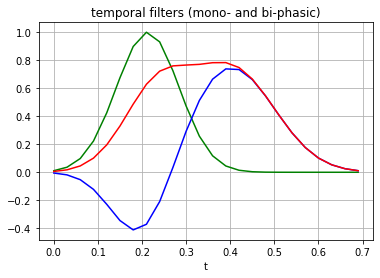

In [10]:
t = np.arange(0.0, 0.7 * scale_factor, 0.03)
temporal_mono_filter = TemporalFilter(mono_mean, mono_sigma)
temporal_bi1_filter = TemporalFilter(bi1_mean, bi1_sigma)
temporal_bi2_filter = TemporalFilter(bi2_mean, bi2_sigma)
t_mono = temporal_mono_filter.get(t)
t_bi = scale_bi1 * temporal_bi1_filter.get(t)
t_bi += scale_bi2 * temporal_bi2_filter.get(t)

fig2, ax1 = plt.subplots()
val_max = np.max([np.max(np.abs(t_mono)), np.max(np.abs(t_bi))])
ax1.plot(t, t_mono / val_max, "g-")
ax1.plot(t, t_bi / val_max, "b-")
ax1.plot(t, (t_mono + t_bi) / val_max, "r-")
ax1.set_title("temporal filters (mono- and bi-phasic)")
ax1.set_xlabel("t")
plt.savefig("temporal_filters_mono_bi.png")
plt.grid()
plt.show()

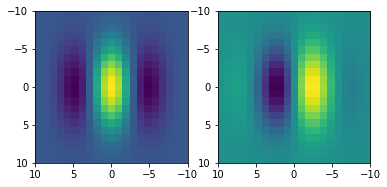

In [11]:
filter_amount = 32
filter_apothem = 10
spatial_sigma = 25

filter_size = filter_apothem * 2 + 1

spatial_even_filters, spatial_odd_filters = \
    generate_spatial_filters(filter_amount, filter_apothem, spatial_sigma, f0x, f0y)

G_even = spatial_even_filters[0]
G_odd = spatial_odd_filters[0]
fig = plt.figure()
axis_extend = [filter_apothem, -filter_apothem, filter_apothem, -filter_apothem]
plt.subplot(1, 2, 1), plt.imshow(G_even, extent=axis_extend)
plt.subplot(1, 2, 2), plt.imshow(G_odd, extent=axis_extend)
plt.savefig("spatial_filters_1.png")

# Note: Shows neuron's response, not the filter itself.

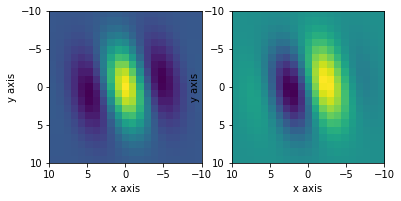

In [12]:
G_even = spatial_even_filters[1]
G_odd = spatial_odd_filters[1]
fig = plt.figure()
plt.subplot(1, 2, 1), plt.xlabel("x axis"), plt.ylabel("y axis")
plt.imshow(G_even, extent=axis_extend)
plt.subplot(1, 2, 2), plt.xlabel("x axis"), plt.ylabel("y axis"),
plt.imshow(G_odd, extent=axis_extend)
plt.savefig("spatial_filters_2.png")

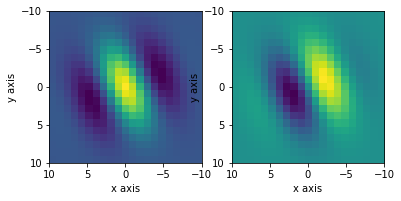

In [13]:
G_even = spatial_even_filters[2]
G_odd = spatial_odd_filters[2]
fig = plt.figure()
plt.subplot(1, 2, 1), plt.xlabel("x axis"), plt.ylabel("y axis")
plt.imshow(G_even, extent=axis_extend)
plt.subplot(1, 2, 2), plt.xlabel("x axis"), plt.ylabel("y axis")
plt.imshow(G_odd, extent=axis_extend)
plt.savefig("spatial_filters_3.png")

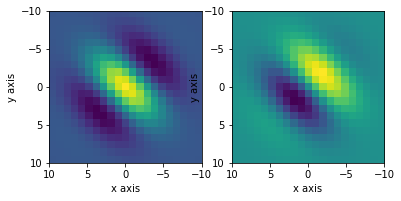

In [14]:
G_even = spatial_even_filters[4]
G_odd = spatial_odd_filters[4]
fig = plt.figure()
plt.subplot(1, 2, 1), plt.xlabel("x axis"), plt.ylabel("y axis")
plt.imshow(G_even, extent=axis_extend)
plt.subplot(1, 2, 2), plt.xlabel("x axis"), plt.ylabel("y axis")
plt.imshow(G_odd, extent=axis_extend)
plt.savefig("spatial_filters_4.png")

<ipython-input-15-070c711db55c>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(nrows, 2 * np.ceil(show_filters / nrows), filter_ * 2 + 1, projection="3d")
<ipython-input-15-070c711db55c>:20: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(nrows, 2 * np.ceil(show_filters / nrows), filter_ * 2 + 2, projection="3d")


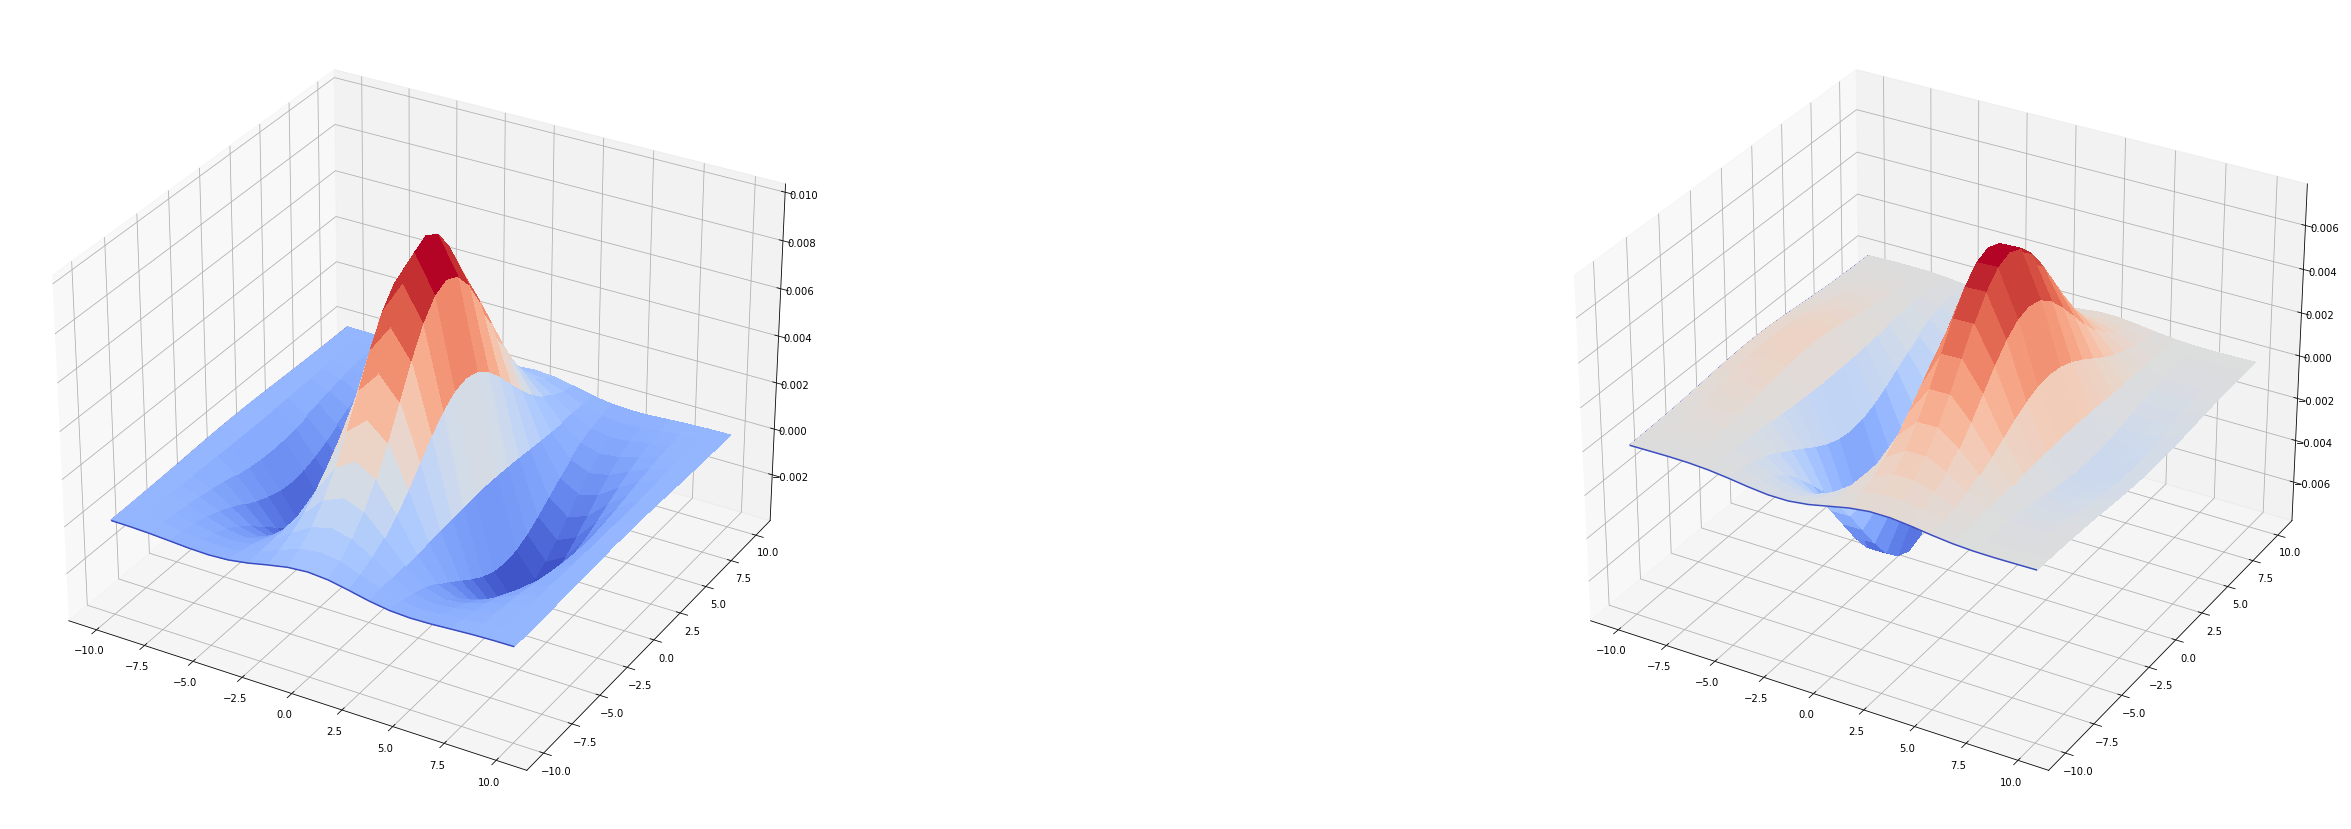

In [15]:
fig = plt.figure(figsize=(50, 15))

val_range = np.arange(-filter_apothem, filter_apothem+1)
X, Y = np.meshgrid(val_range, val_range)

show_filters = 1
nrows = 1

for filter_ in range(show_filters):
    ev_filter = spatial_even_filters[filter_]
    odd_filter = spatial_odd_filters[filter_]
    ax = fig.add_subplot(nrows, 2 * np.ceil(show_filters / nrows), filter_ * 2 + 1, projection="3d")    
    ax.plot_surface(X, Y, ev_filter, rstride=1, cstride=1, cmap=cm.coolwarm, \
                    linewidth=0, antialiased=False)
    # ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.25)
    ax.contour(X, Y, ev_filter, zdir="z", cmap=cm.coolwarm)
    ax.contour(X, Y, ev_filter, zdir="x", cmap=cm.coolwarm)
    ax.contour(X, Y, ev_filter, zdir="y", cmap=cm.coolwarm)
    
    ax = fig.add_subplot(nrows, 2 * np.ceil(show_filters / nrows), filter_ * 2 + 2, projection="3d")    
    ax.plot_surface(X, Y, odd_filter, rstride=1, cstride=1, cmap=cm.coolwarm, \
                    linewidth=0, antialiased=False)
    # ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.25)
    ax.contour(X, Y, odd_filter, zdir="z", cmap=cm.coolwarm)
    ax.contour(X, Y, odd_filter, zdir="x", cmap=cm.coolwarm)
    ax.contour(X, Y, odd_filter, zdir="y", cmap=cm.coolwarm)
    
    # cb = fig.colorbar(p, shrink=0.5)
#     ax.set_title(" filter bank " + str(i) + "/8 pi")
#     ax.set_zlabel("Z", fontdict={"size": 15, "color": "red"})
#     ax.set_ylabel("Y", fontdict={"size": 15, "color": "red"})
#     ax.set_xlabel("X", fontdict={"size": 15, "color": "red"})

plt.savefig("spatial_3d.png")
plt.show()

In [16]:
space_time_filters = []
filters_to_pi = filter_amount // 2
for i in range(filters_to_pi):
    G_even = spatial_even_filters[i]
    G_odd = spatial_odd_filters[i]
    space_time_kernel = G_even[:, :, None] * t_bi + G_odd[:, :, None] * t_mono
    space_time_filters.append(space_time_kernel)

<Figure size 432x288 with 0 Axes>

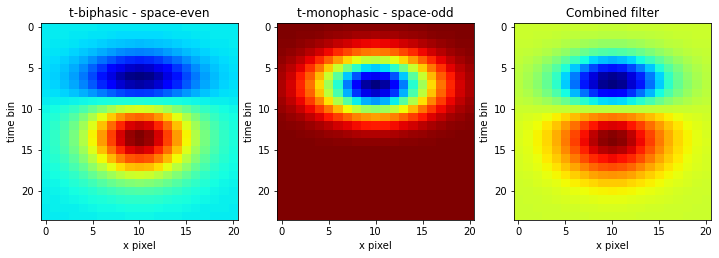

In [17]:
# Plot an x-t slice of each component of the space-time filter
# Fig 3 in the 2014 paper
slice_idx = filter_apothem  # index of the central y-slice, transposed

fig = plt.figure()
plt.figure(figsize=(12,12))

num_bins_t = len(t_mono)

filter_index = 0
space_time_kernel_even = spatial_even_filters[filter_index][:, :, None] * t_bi
space_time_kernel_odd = spatial_odd_filters[filter_index][:, :, None] * t_mono
space_time_kernel_sum = space_time_kernel_even + space_time_kernel_odd

slice_idx = 15
sliced_st_even = space_time_kernel_even[:, slice_idx, :]
sliced_st_odd = space_time_kernel_odd[:, slice_idx, :]
sliced_st_sum = space_time_kernel_sum[:, slice_idx, :]


plt.subplot(1, 3, 1)

set_aspect_val = filter_size / num_bins_t

plt.imshow(np.transpose(sliced_st_even), cmap='jet_r')
#plt.gca().invert_yaxis()
plt.gca().set_aspect(set_aspect_val)
plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("t-biphasic - space-even")
plt.savefig("filters1.png")
plt.subplot(1, 3, 2),
plt.imshow(np.transpose(sliced_st_odd), cmap='jet_r')
plt.gca().set_aspect(set_aspect_val)
plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("t-monophasic - space-odd")
plt.savefig("filters2.png")
plt.subplot(1, 3, 3),
plt.imshow(np.transpose(sliced_st_sum), cmap='jet_r')
plt.gca().set_aspect(set_aspect_val)
plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("Combined filter")
plt.savefig("filters3.png")


<Figure size 432x288 with 0 Axes>

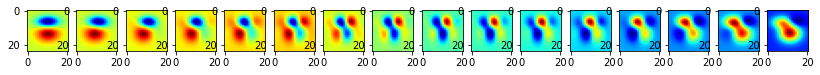

In [18]:
# Show filters
fig = plt.figure()
plt.figure(figsize=(14,14))
num_filters = len(space_time_filters)
# print(filters[0][:,5,:])
for i in range(num_filters):
    plt.subplot(1,num_filters, i+1),
    plt.imshow(np.transpose(space_time_filters[i][:,slice_idx,:]), cmap='jet_r')
    #plt.gca().invert_yaxis()
    plt.gca().set_aspect( (filter_size / num_bins_t) )

In [19]:
plt.savefig("spacetime.png")

<Figure size 432x288 with 0 Axes>

In [20]:
# Compute response of the filter to a given input. See description in LNAI8774 2014
# Bio-inspired optic flow from event-based neuromorphic sensor input, Section 3

In [21]:
# Temporal filters become 0 when t_diff > 0.07
# So we can get a period that uses such
t_diff = 0.7

t_start = event_list[0][0]
t_end = t_start + t_diff


start_ind = 0 # replace with searchsorted left if not 0
stop_ind = np.searchsorted(event_list['t'], t_end, "left")

event_subset = event_list[start_ind:stop_ind]
print("Number of events: {}".format(stop_ind))
print("Time interval: {} : {}".format(t_start, t_end))

Number of events: 263749
Time interval: 0.0 : 0.7


In [22]:
# First, try the synchronous solution: convert the events to a 3D voxel grid by voting:
# each events fills in some part of the 3D grid, according to a Gaussian weights in space and time

# DAVIS camera pixel resolution
sensor_width = 240
sensor_height = 180

# Select sub-region of the image
band_width = 240
band_height = 180

In [23]:
filter_amount = 4
spatial_even_filters, spatial_odd_filters = \
    generate_spatial_filters(filter_amount, filter_apothem, spatial_sigma, f0x, f0x)

In [24]:
def get_axis_indices(x, start_val, end_val, filter_apothem, filter_size):
    # @param x: index for the selected axis
    # @param start_val: is 0 for whole image
    # @param end_val: is band_width / height for whole image
    # @param filter_dilation: on x axis / y axis etc.
    # @return x_start, x_stop: the image region to be summed with filter output.
    # @return x_filter_start, x_filter_stop: the filter region to be added to image region
    
    x_start_region = x - filter_apothem
        
    if x_start_region < start_val:
        x_start = start_val
        x_filter_start = -x_start_region
    else:
        x_start = x_start_region
        x_filter_start = 0
    
    x_stop_region = x + filter_apothem + 1
    
    if x_stop_region > end_val:
        x_stop = end_val
        x_filter_stop = filter_size - (x_stop_region - end_val)
    else:
        x_stop = x_stop_region
        x_filter_stop = filter_size
        
    return x_start, x_stop, x_filter_start, x_filter_stop

In [25]:
def get_filtered_image(event_data, t_end,
                       start_x_img, start_y_img, stop_x_img, stop_y_img, 
                       filter_amount, filter_apothem, f0x,
                       temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                       scale_biphasic1, scale_biphasic2,
                       spatial_even_filters, spatial_odd_filters
                      ):
    
    # Flip filter axes so neuron's response can be modeled.
    # For example, a neuron in (-10, -10) will response as in (10, 10)
    # and vice versa

    even_filters = np.flip(spatial_even_filters, axis=(1,2))
    odd_filters = np.flip(spatial_odd_filters, axis=(1,2))
    
    even_filters = np.moveaxis(even_filters, 0, 2)
    odd_filters = np.moveaxis(odd_filters, 0, 2)
    
    
    pixels_x = stop_x_img - start_x_img
    pixels_y = stop_y_img - start_y_img
    
    # order is reversed for band_height - width for x, y indexing as in a picture
    grid_vox = np.zeros((pixels_y, pixels_x, filter_amount), dtype=np.float64)
    
    stop_index = len(event_data)
    
    filter_size = 2 * filter_apothem + 1
    
    for index in np.arange(0, stop_index):
        t, x, y = event_subset[index]

        # Compute temporal filter

        t_diff = t_end - t

        temporal_monophasic = temporal_mono_filter.get(t_diff)
        temporal_biphasic = scale_biphasic1 * temporal_bi1_filter.get(t_diff)
        temporal_biphasic += scale_biphasic2 * temporal_bi2_filter.get(t_diff)

        x_start, x_stop, x_filter_start, x_filter_stop = \
            get_axis_indices(x, 0, band_width, filter_apothem, filter_size)
        y_start, y_stop, y_filter_start, y_filter_stop = \
            get_axis_indices(y, 0, band_height, filter_apothem, filter_size)

        even_filter_val = temporal_biphasic * even_filters
        odd_filter_val = temporal_monophasic * odd_filters        
        filter_val = even_filter_val + odd_filter_val

        grid_vox[y_start:y_stop, x_start:x_stop] += \
            filter_val[y_filter_start:y_filter_stop, x_filter_start:x_filter_stop]
    
    return grid_vox

In [26]:
def get_filtered_image_2(event_data, t_end,
                       start_x_img, start_y_img, stop_x_img, stop_y_img, 
                       filter_amount, filter_apothem, f0x,
                       temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                       scale_biphasic1, scale_biphasic2,
                       spatial_even_filters, spatial_odd_filters
                      ):\
    
    even_filters = np.moveaxis(spatial_even_filters, 0, 2)
    odd_filters = np.moveaxis(spatial_odd_filters, 0, 2)
    
    pixels_x = stop_x_img - start_x_img
    pixels_y = stop_y_img - start_y_img
    
    # order is reversed for band_height - width for x, y indexing as in a picture
    image_phasic = np.zeros((2, pixels_y, pixels_x), dtype=np.float64)
    
    stop_index = len(event_data)
    
    filter_size = 2 * filter_apothem + 1
    
    for index in np.arange(0, stop_index):
        t, x, y = event_subset[index]

        # Compute temporal filter

        t_diff = t_end - t
        
        # Start with even_filter's component, biphasic. Plus 0 is even
        image_phasic[0, y, x] += scale_biphasic1 * temporal_bi1_filter.get(t_diff) + \
            scale_biphasic2 * temporal_bi2_filter.get(t_diff)
        image_phasic[1, y, x] += temporal_mono_filter.get(t_diff)
    
    
    image_filtered = np.zeros(( pixels_y, pixels_x, filter_amount), dtype=np.float64)

    for y in np.arange(band_height):
        for x in np.arange(band_width):
            x_start, x_stop, x_filter_start, x_filter_stop = \
                get_axis_indices(x, 0, band_width, filter_apothem, filter_size)
            y_start, y_stop, y_filter_start, y_filter_stop = \
                get_axis_indices(y, 0, band_height, filter_apothem, filter_size)
            
            for i in np.arange(filter_amount):
                image_filtered[y, x] += np.sum(
                    image_phasic[0, y_start:y_stop, x_start:x_stop, None] * even_filters[y_filter_start:y_filter_stop, x_filter_start:x_filter_stop] +
                    image_phasic[1, y_start:y_stop, x_start:x_stop, None] * odd_filters[y_filter_start:y_filter_stop, x_filter_start:x_filter_stop],
                    axis=(0,1)
                )
    return image_filtered

In [27]:
def get_filtered_image(event_data, t_end,
                       start_x_img, start_y_img, stop_x_img, stop_y_img, 
                       filter_amount, filter_apothem, f0x,
                       temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                       scale_biphasic1, scale_biphasic2,
                       spatial_even_filters, spatial_odd_filters
                      ):
    
    even_filters = np.asarray(spatial_even_filters)
    odd_filters = np.asarray(spatial_odd_filters)
    
    pixels_x = stop_x_img - start_x_img
    pixels_y = stop_y_img - start_y_img
    
    # order is reversed for band_height - width for x, y indexing as in a picture
    image_phasic = np.zeros((2, pixels_y, pixels_x), dtype=np.float64)
    
    stop_index = len(event_data)
    
    filter_size = 2 * filter_apothem + 1
    
    for index in np.arange(0, stop_index):
        t, x, y = event_subset[index]

        # Compute temporal filter

        t_diff = t_end - t
        
        # Start with even_filter's component, biphasic. Plus 0 is even
        image_phasic[0, y, x] += scale_biphasic1 * temporal_bi1_filter.get(t_diff) + \
            scale_biphasic2 * temporal_bi2_filter.get(t_diff)
        image_phasic[1, y, x] += temporal_mono_filter.get(t_diff)
    
    
    image_filtered = np.zeros(( pixels_y, pixels_x, filter_amount), dtype=np.float64)

    for i in range(filter_amount):
        image_filtered[:,:,i] = cv2.filter2D(image_phasic[0], -1, even_filters[i], borderType=cv2.BORDER_ISOLATED)
        image_filtered[:,:,i] += cv2.filter2D(image_phasic[1], -1, odd_filters[i], borderType=cv2.BORDER_ISOLATED)        
        
    return image_filtered

In [28]:
%%time
grid_vox = get_filtered_image(event_subset, t_end,
                              0, 0, band_width, band_height,
                              filter_amount, filter_apothem, f0x,
                              temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                              scale_bi1, scale_bi2,
                              spatial_even_filters, spatial_odd_filters)

Wall time: 4.22 s


In [29]:
print(grid_vox.shape)

(180, 240, 4)


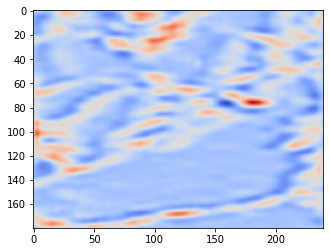

In [30]:
res = np.sum(grid_vox, axis=2)
plt.imshow(res, cmap=cm.coolwarm)
plt.savefig("res.png")
np.save("input_data.npy", grid_vox)
# python scripts/visualize_dsi_volume.py -i input_data.npy

In [31]:
grid_vox_unoptimized = get_filtered_image(event_subset, t_end,
                              0, 0, band_width, band_height,
                              filter_amount, filter_apothem, f0x,
                              temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                              scale_bi1, scale_bi2,
                              spatial_even_filters, spatial_odd_filters)

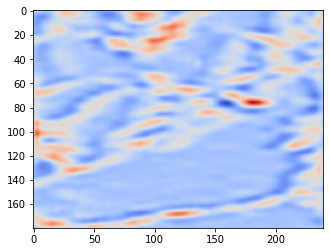

In [32]:
res = np.sum(grid_vox_unoptimized, axis=2)
plt.imshow(res, cmap=cm.coolwarm)
plt.savefig("res.png")
np.save("input_data.npy", grid_vox)
# python scripts/visualize_dsi_volume.py -i input_data.npy

<Figure size 432x288 with 0 Axes>

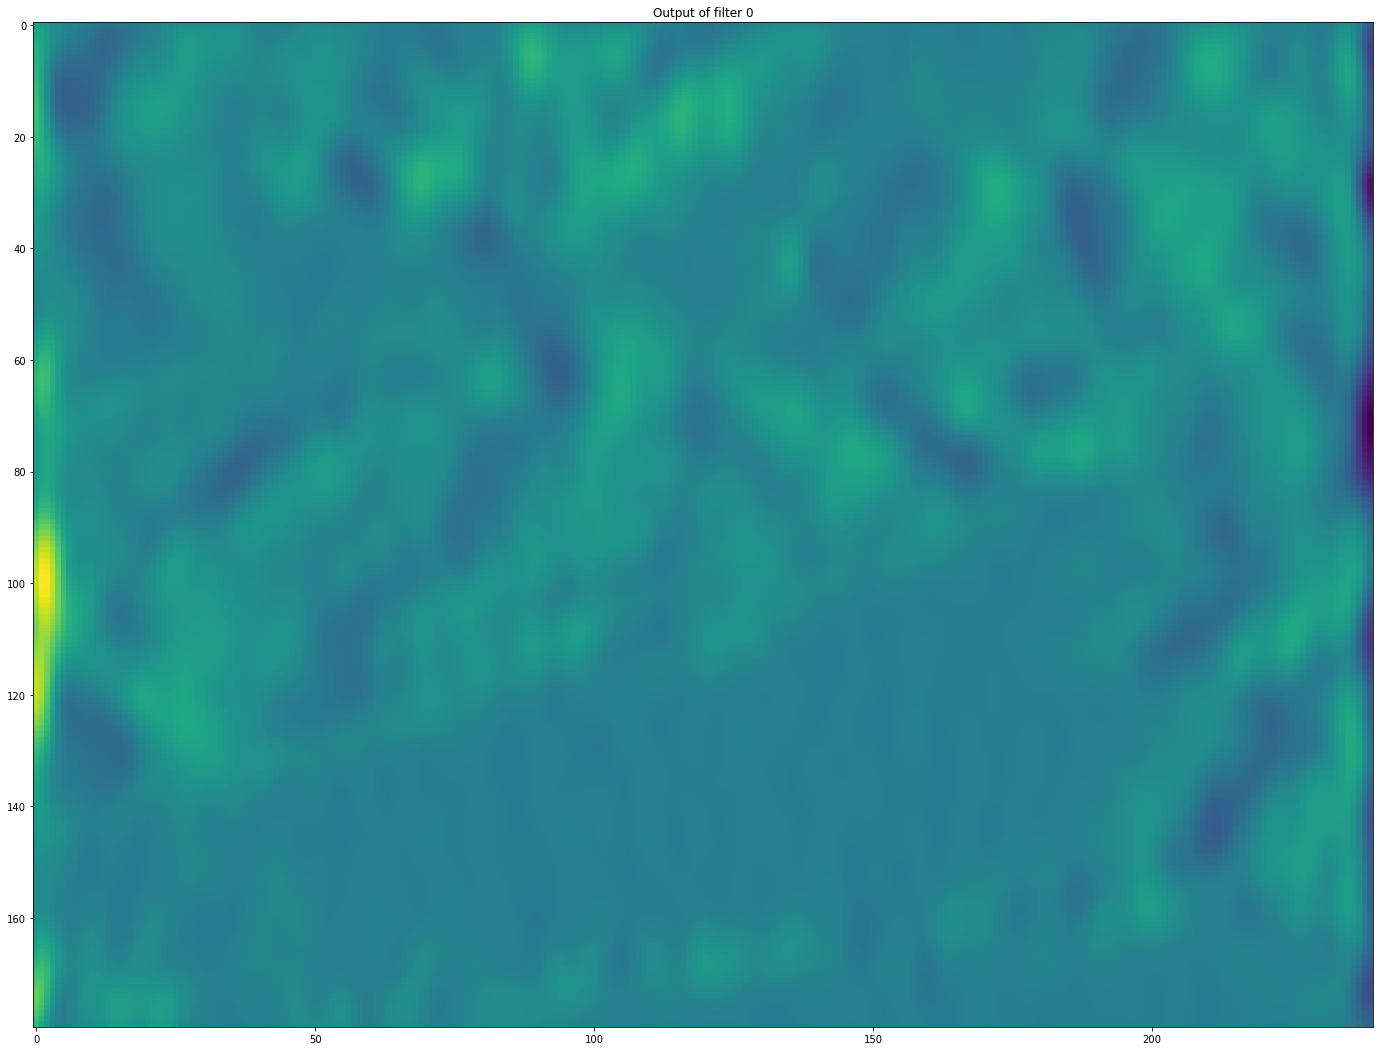

In [33]:
# Visualize results
fig = plt.figure()
plt.figure(figsize=(24, 24))

filters_to_show = filter_amount // 4

for i in range(filters_to_show):
    plt.subplot(1, filters_to_show, i+1)
    plt.imshow(grid_vox[:,:,i])
    plt.title("Output of filter " + str(i))

In [34]:
u = np.zeros((band_height, band_width), dtype=np.float32)
v = np.zeros((band_height, band_width), dtype=np.float32)
for k in range(filter_amount):
    # there is no minus in sin, which I think is correct.
    # this is due to -theta in filter.
    u = u + np.cos(tau * k / filter_amount) * grid_vox[:,:,k]
    v = v + np.sin(tau * k / filter_amount) * grid_vox[:,:,k]

In [35]:
u_unoptimized = np.zeros((band_height, band_width), dtype=np.float32)
v_unoptimized = np.zeros((band_height, band_width), dtype=np.float32)
for k in range(filter_amount):
    # there is no minus in sin, which I think is correct.
    # this is due to -theta in filter.
    u_unoptimized = u_unoptimized + np.cos(tau * k / filter_amount) * grid_vox_unoptimized[:,:,k]
    v_unoptimized = v_unoptimized + np.sin(tau * k / filter_amount) * grid_vox_unoptimized[:,:,k]

In [36]:
def quiver_show_subset(u, v, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop):
    
    u_subspace = u[y_subspace_start:y_subspace_stop, x_subspace_start:x_subspace_stop]
    v_subspace = v[y_subspace_start:y_subspace_stop, x_subspace_start:x_subspace_stop]

    u_subspace = u_subspace[::-1]
    v_subspace = v_subspace[::-1]
    
    x_subspace = np.arange(x_subspace_start, x_subspace_stop)
    y_subspace = np.arange(y_subspace_start, y_subspace_stop)
    x_subspace, y_subspace = np.meshgrid(x_subspace, y_subspace)
    
    fig = plt.figure(figsize=(24, 18))
    #img = np.zeros((y_subspace_stop - y_subspace_start, x_subspace_stop - x_subspace_start))
    #plt.imshow(img, origin="upper", cmap="binary")
    plt.quiver(u_subspace, v_subspace, color="r")

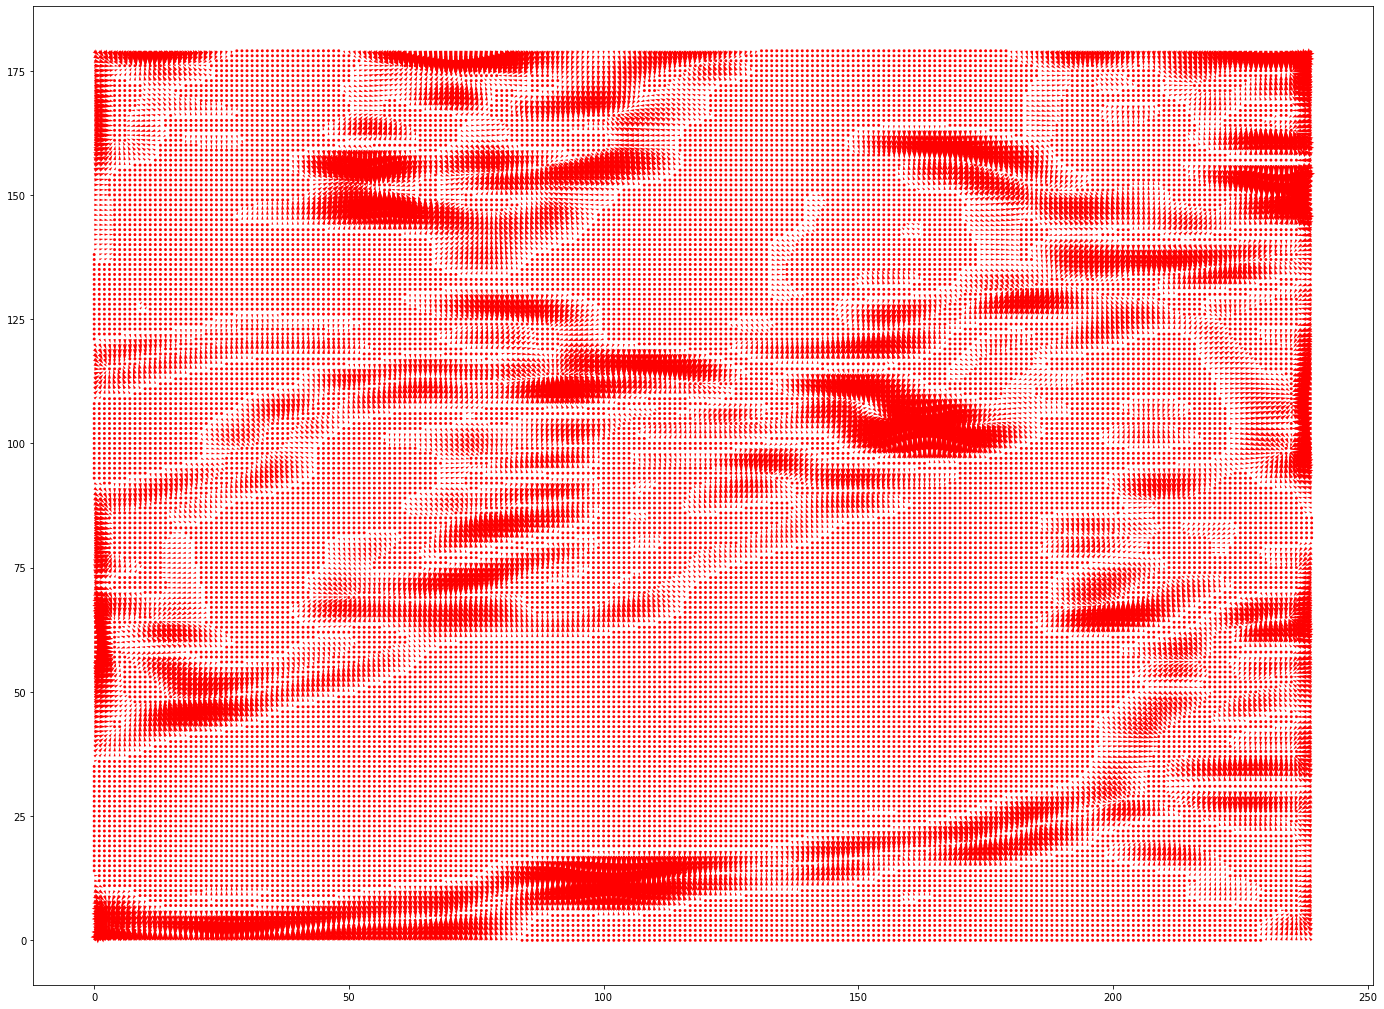

In [37]:
quiver_show_subset(u, v, 0, band_width, 0, band_height)
plt.savefig("whole_image.png")

In [38]:
def quiver_show_subset_with_figure(u, v, 
                                   x_subspace_start, x_subspace_stop, 
                                   y_subspace_start, y_subspace_stop
                                  ):
    u_subspace = u[y_subspace_start:y_subspace_stop, x_subspace_start:x_subspace_stop]
    v_subspace = v[y_subspace_start:y_subspace_stop, x_subspace_start:x_subspace_stop]

    x_subspace = np.arange(x_subspace_start, x_subspace_stop)
    y_subspace = np.arange(y_subspace_start, y_subspace_stop)
    x_subspace, y_subspace = np.meshgrid(x_subspace, y_subspace)
    
    fig = plt.figure(figsize=(24, 18))
    img = np.zeros((y_subspace_stop - y_subspace_start, x_subspace_stop - x_subspace_start))
    plt.imshow(img, origin="upper", cmap="binary")
    plt.quiver(u_subspace, v_subspace, color="r")

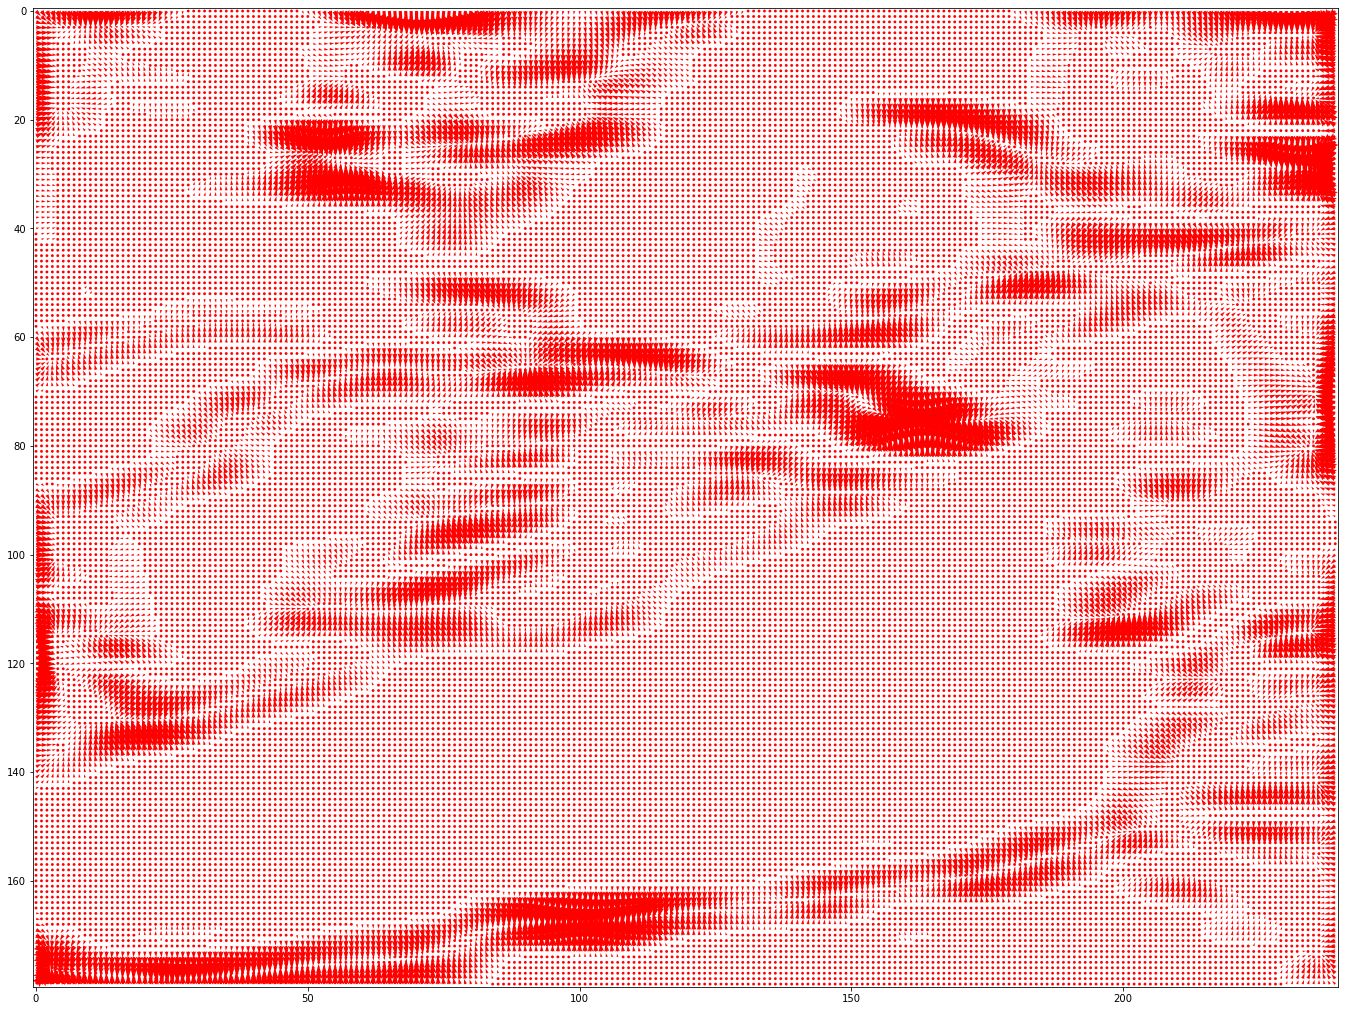

In [39]:
quiver_show_subset_with_figure(u, v, 0, band_width, 0, band_height)

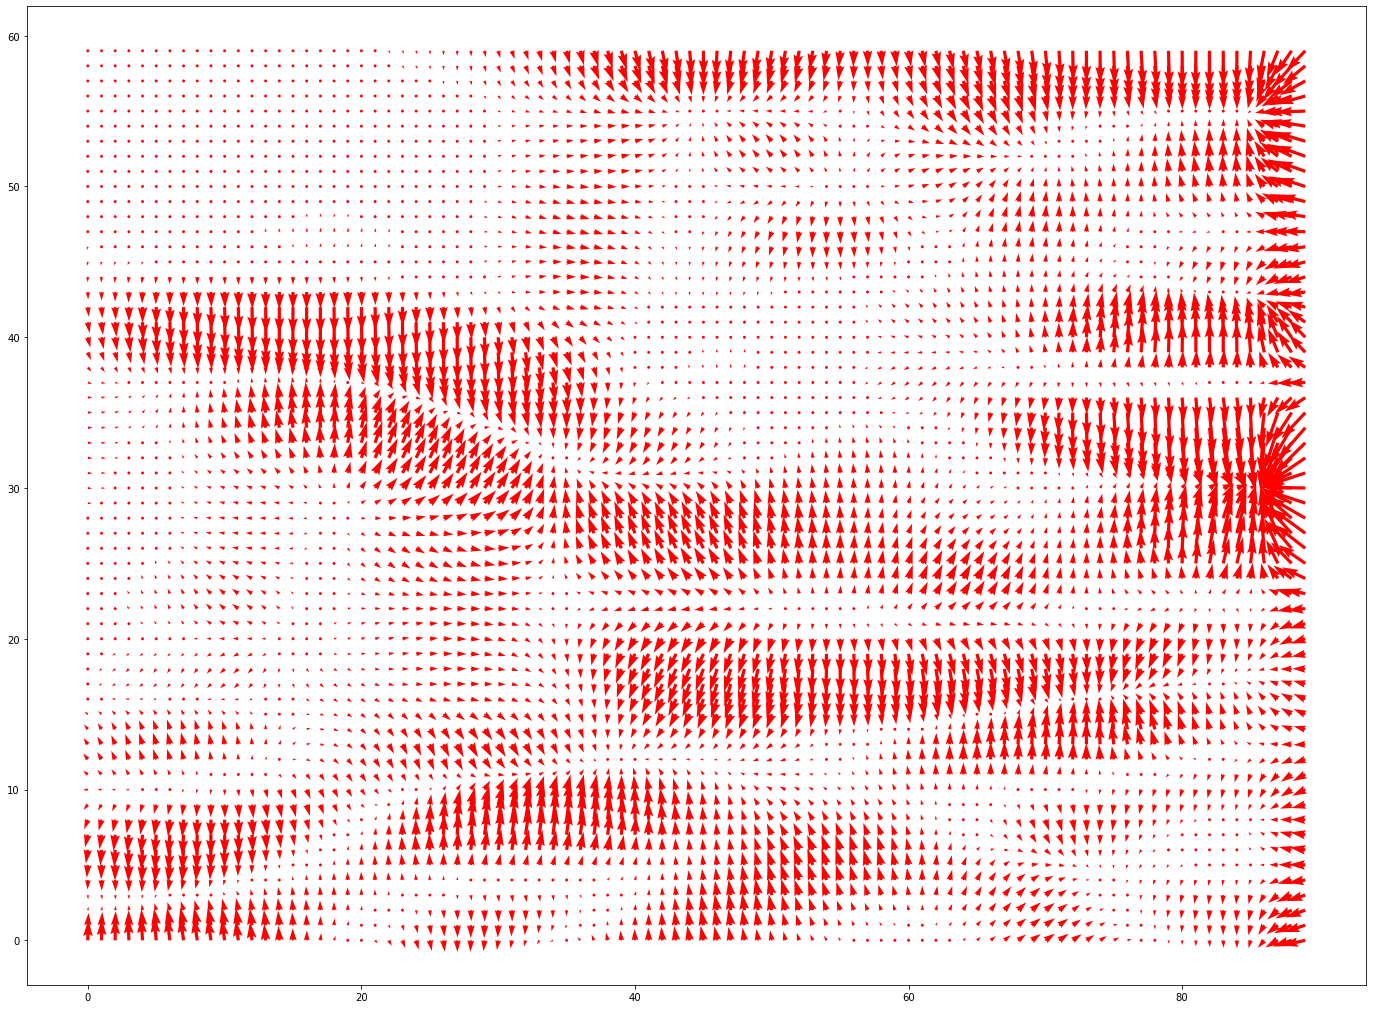

In [40]:
x_subspace_start = 150
x_subspace_stop = 240
y_subspace_start = 0
y_subspace_stop = 60

quiver_show_subset(u, v, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image.png")

Wall time: 10.1 s


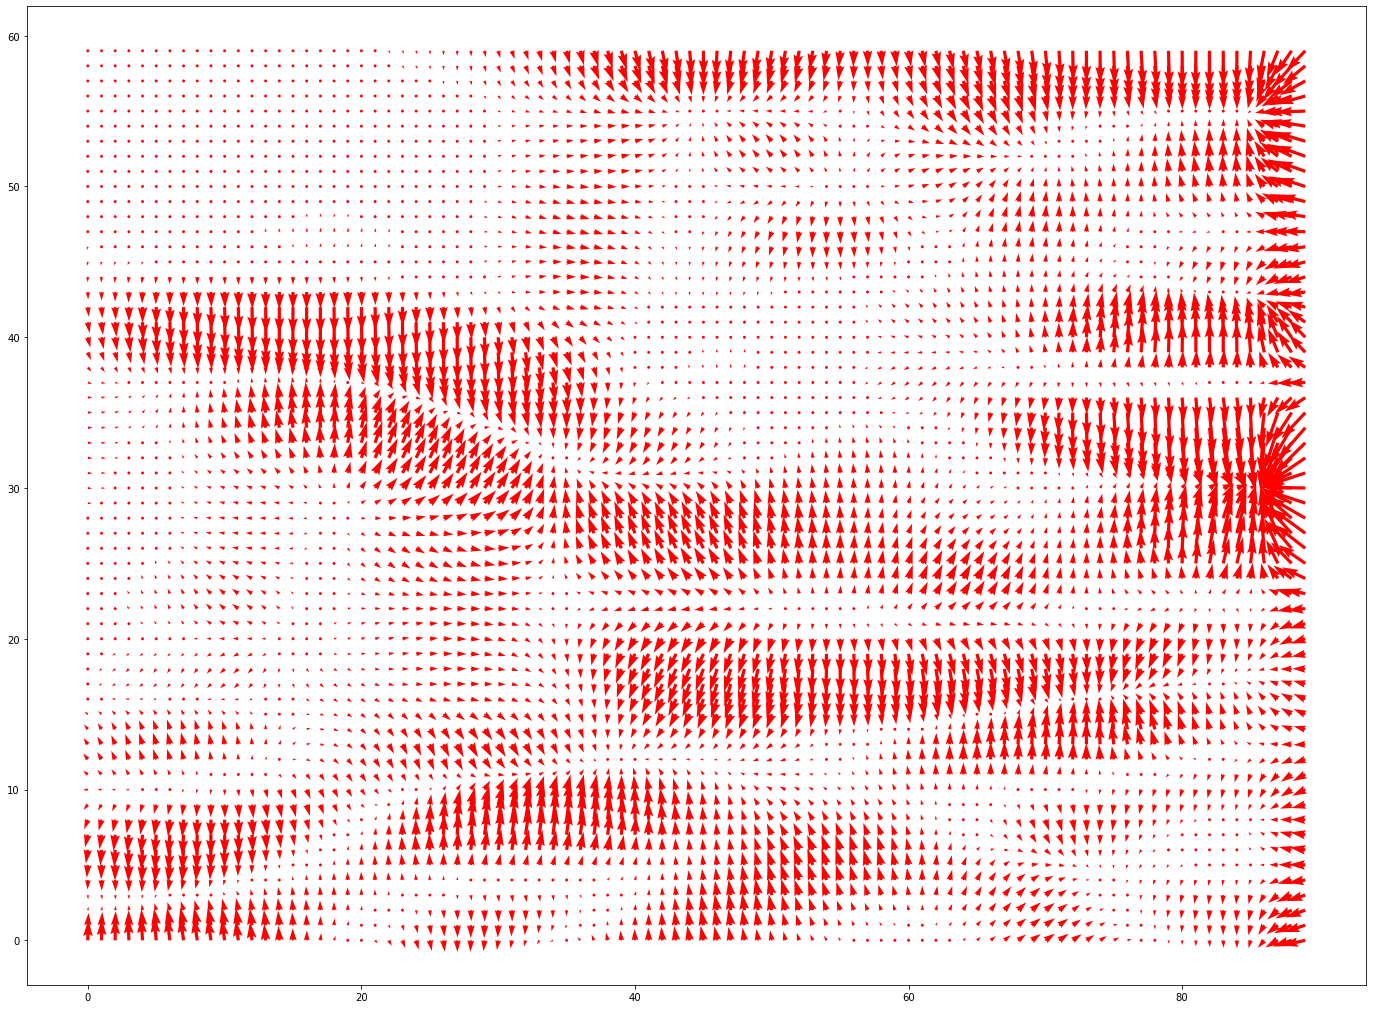

In [41]:
%%time
grid_vox_2 = get_filtered_image_2(event_subset, t_end,
                              0, 0, band_width, band_height,
                              filter_amount, filter_apothem, f0x,
                              temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                              scale_bi1, scale_bi2,
                              spatial_even_filters, spatial_odd_filters)

u_2 = np.zeros((band_height, band_width), dtype=np.float32)
v_2 = np.zeros((band_height, band_width), dtype=np.float32)
for k in range(filter_amount):
    # there is no minus in sin, which I think is correct.
    # this is due to -theta in filter.
    u_2 = u_2 + np.cos(tau * k / filter_amount) * grid_vox_2[:,:,k]
    v_2 = v_2 + np.sin(tau * k / filter_amount) * grid_vox_2[:,:,k]
    
quiver_show_subset(u_2, v_2, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)

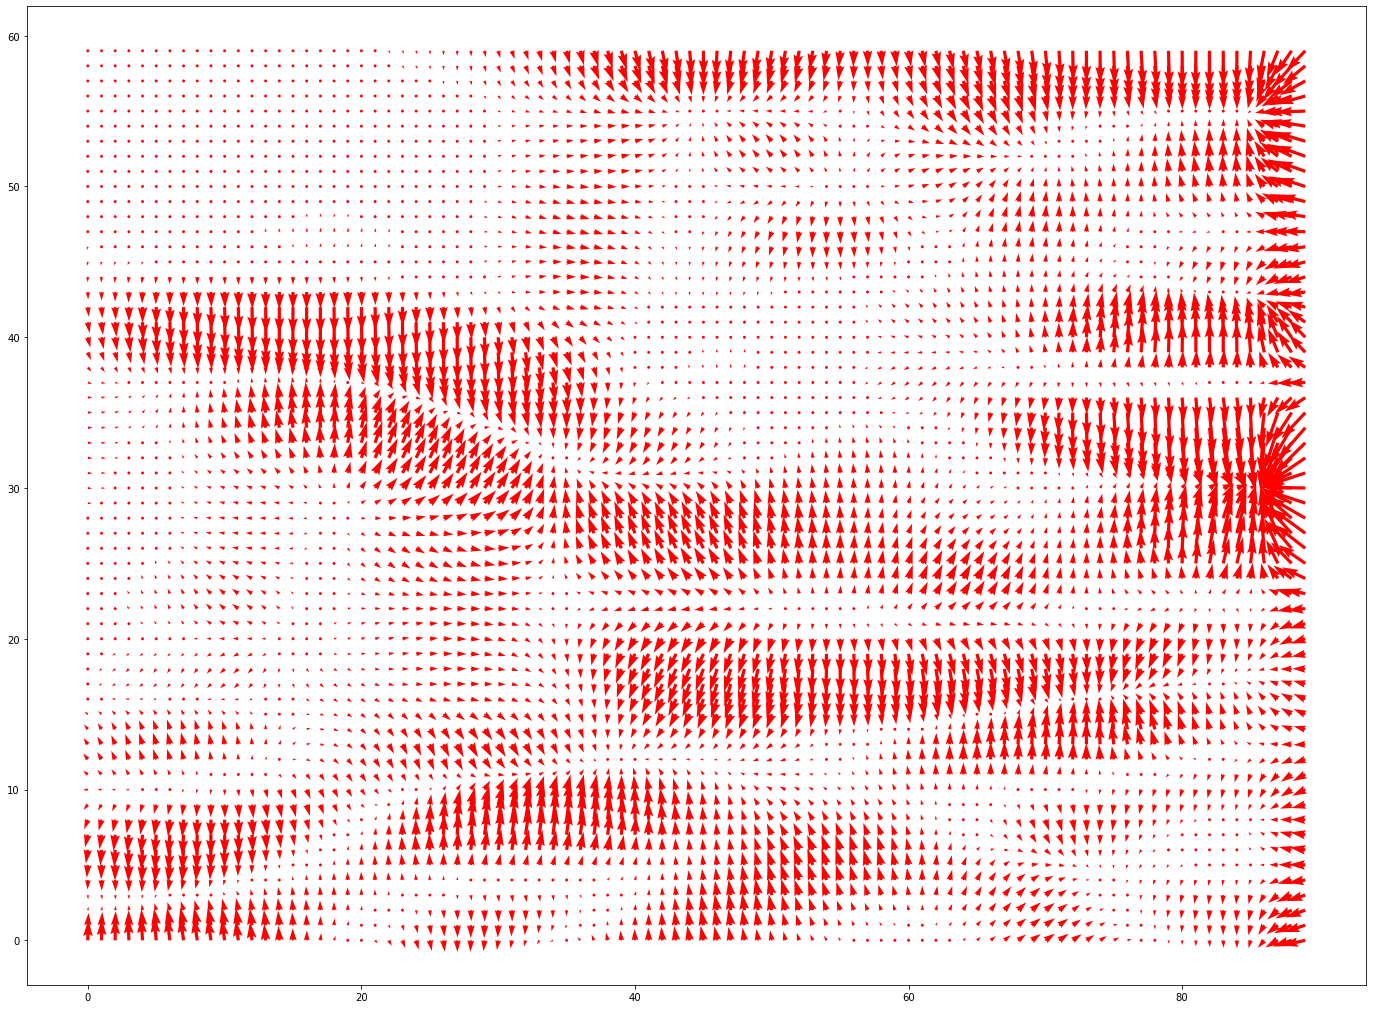

In [42]:
x_subspace_start = 150
x_subspace_stop = 240
y_subspace_start = 0
y_subspace_stop = 60

quiver_show_subset(u_unoptimized, v_unoptimized, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image.png")

In [43]:
def normalize(u, v):
    beta_response = 1
    alpha_p = 0.1
    alpha_q = 0.002
    sigma_response = 3.6

    center = np.ceil(sigma_response * 3)
    size = center * 2 + 1

    filter_gaussian = cv2.getGaussianKernel(size, sigma_response)

    def relu(x):
        return x * (x > 0)

    uv_response = np.sqrt(u**2 + v**2)

    relu_response = relu(uv_response)
    gaussian_response = cv2.filter2D(relu_response, -1, filter_gaussian)
    normalized_response = beta_response * uv_response / (alpha_p + uv_response + relu(gaussian_response / alpha_q))

    ratio = normalized_response / uv_response
    u_normalized = ratio * u
    v_normalized = ratio * v

    return u_normalized, v_normalized

u_normalized, v_normalized = normalize(u, v)

TypeError: integer argument expected, got float

In [ ]:
quiver_show_subset_with_figure(u, v, 0, band_width, 0, band_height)

In [ ]:
quiver_show_subset(u_normalized, v_normalized, 0, band_width, 0, band_height)
plt.savefig("whole_image_normalized.png")

In [ ]:
quiver_show_subset(u_normalized, v_normalized, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image_normalized.png")

In [ ]:
def get_filtered_image_time(event_data, t_end,
                       start_x_img, start_y_img, stop_x_img, stop_y_img, 
                       filter_amount, filter_apothem, f0x,
                       temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                       scale_biphasic1, scale_biphasic2,
                       spatial_even_filters, spatial_odd_filters
                      ):
    
    even_filters = np.asarray(spatial_even_filters)
    odd_filters = np.asarray(spatial_odd_filters)
    
    even_filters = np.moveaxis(even_filters, 0, 2)
    odd_filters = np.moveaxis(odd_filters, 0, 2)
    
    
    pixels_x = stop_x_img - start_x_img
    pixels_y = stop_y_img - start_y_img
    
    # order is reversed for band_height - width for x, y indexing as in a picture
    grid_vox = np.zeros((pixels_y, pixels_x, filter_amount), dtype=np.float64)
    
    stop_index = len(event_data)
    
    filter_size = 2 * filter_apothem + 1
    
    for index in np.arange(0, stop_index):
        t, x, y = event_subset[index]

        # Compute temporal filter

        t_diff = t_end - t

        temporal_monophasic = temporal_mono_filter.get(t_diff)
        temporal_biphasic = scale_biphasic1 * temporal_bi1_filter.get(t_diff)
        temporal_biphasic += scale_biphasic2 * temporal_bi2_filter.get(t_diff)

        temporal_monophasic = np.sum(temporal_monophasic)
        temporal_biphasic = np.sum(temporal_biphasic)
        
        x_start, x_stop, x_filter_start, x_filter_stop = \
            get_axis_indices(x, 0, band_width, filter_apothem, filter_size)
        y_start, y_stop, y_filter_start, y_filter_stop = \
            get_axis_indices(y, 0, band_height, filter_apothem, filter_size)

        even_filter_val = temporal_biphasic * even_filters
        odd_filter_val = temporal_monophasic * odd_filters        
        filter_val = even_filter_val + odd_filter_val

        grid_vox[y_start:y_stop, x_start:x_stop] += \
            filter_val[y_filter_start:y_filter_stop, x_filter_start:x_filter_stop]
    
    return grid_vox

In [ ]:
t_range = np.arange(7, 15) * 0.1

t_start = event_list[0][0]
t_end = t_range[-1]

start_ind = 0 # replace with searchsorted left if not 0
stop_ind = np.searchsorted(event_list['t'], t_end, "left")

event_subset = event_list[start_ind:stop_ind]
print("Number of events: {}".format(stop_ind))
print("Time interval: {} : {}".format(t_start, t_end))

%time
grid_vox = get_filtered_image_time(event_subset, t_range,
                              0, 0, band_width, band_height,
                              filter_amount, filter_apothem, f0x,
                              temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                              scale_bi1, scale_bi2,
                              spatial_even_filters, spatial_odd_filters)

In [ ]:
u = np.zeros((band_height, band_width), dtype=np.float32)
v = np.zeros((band_height, band_width), dtype=np.float32)
for k in range(filter_amount):
    # there is no minus in sin, which I think is correct.
    # this is due to -theta in filter.
    u = u + np.cos(tau * k / filter_amount) * grid_vox[:,:,k]
    v = v + np.sin(tau * k / filter_amount) * grid_vox[:,:,k]

In [ ]:
quiver_show_subset(u, v, 0, band_width, 0, band_height)
plt.savefig("whole_image_over_time.png")

In [ ]:
quiver_show_subset(u, v, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image_over_time.png")

In [ ]:
u_normalized, v_normalized = normalize(u, v)

quiver_show_subset(u_normalized, v_normalized, 0, band_width, 0, band_height)
plt.savefig("whole_image_over_time_normalized.png")

In [ ]:
quiver_show_subset(u_normalized, v_normalized, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image_over_time_normalized.png")

In [ ]:
# Temporal filters become 0 when t_diff > 0.07
# So we can get a period that uses such
t_diff = 0.7

t_start = event_list[0][0]
t_end = t_start + t_diff


start_ind = 0 # replace with searchsorted left if not 0
stop_ind = np.searchsorted(event_list['t'], t_end, "left")

event_subset = event_list[start_ind:stop_ind]
print("Number of events: {}".format(stop_ind))
print("Time interval: {} : {}".format(t_start, t_end))

filter_amount = 4
spatial_even_filters, spatial_odd_filters = \
    generate_spatial_filters(filter_amount, filter_apothem, spatial_sigma, f0x, f0x)

grid_vox = get_filtered_image_optimized(event_subset, t_end,
                              0, 0, band_width, band_height,
                              filter_amount, filter_apothem, f0x,
                              temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                              scale_bi1, scale_bi2,
                              spatial_even_filters, spatial_odd_filters)

u_small_filters = np.zeros((band_height, band_width), dtype=np.float32)
v_small_filters = np.zeros((band_height, band_width), dtype=np.float32)
for k in range(filter_amount):
    # there is no minus in sin, which I think is correct.
    # this is due to -theta in filter.
    u_small_filters = u_small_filters + np.cos(tau * k / filter_amount) * grid_vox[:,:,k]
    v_small_filters = v_small_filters + np.sin(tau * k / filter_amount) * grid_vox[:,:,k]
    
quiver_show_subset(u_small_filters, v_small_filters, 0, band_width, 0, band_height)
plt.savefig("whole_image_small.png")

quiver_show_subset(u_small_filters, v_small_filters, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image_small.png")

u_small_norm, v_small_norm = normalize(u_small_filters, v_small_filters)
quiver_show_subset(u_small_norm, v_small_norm, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image_small_norm.png")

In [ ]:
diff_u = u - u_small_norm
diff_v = v - v_small_norm

quiver_show_subset(diff_u, diff_v, 0, band_width, 0, band_height)
plt.savefig("whole_image_small_diff.png")

quiver_show_subset(diff_u, diff_v, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image_small_diff.png")

In [ ]:
print(np.max(np.abs(diff_u)), np.max(np.abs(diff_v)))
print(np.sum(np.abs(diff_u) > 10))
print(np.sum(np.abs(diff_v) > 10))
print(np.product(diff_u.shape))

In [ ]:
diff_u_norm = u_normalized - u_small_norm
diff_v_norm = v_normalized - v_small_norm

quiver_show_subset(diff_u_norm, diff_v_norm, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image_small_norm_diff.png")